# Connect to GDrive and set working directory
## !! Skip if you run in local !!
1. Add a shortcut for working directory('IDPCode') to your drive as depicted below:
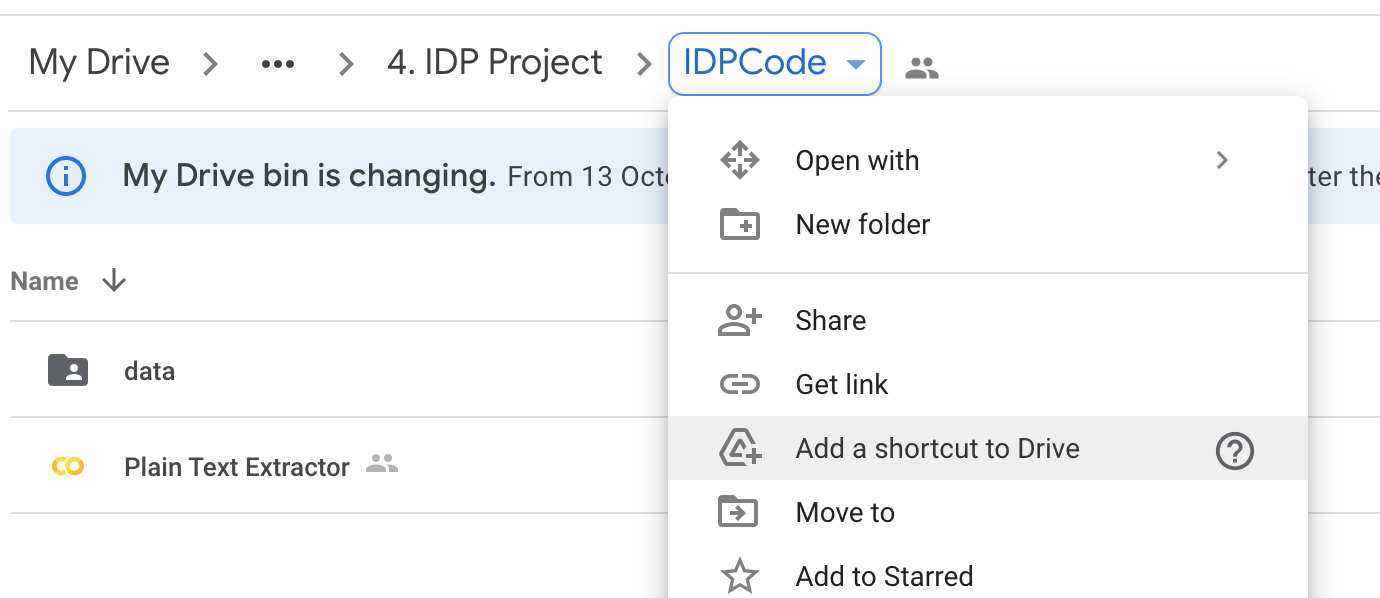
2. Run the command below to connect the GDrive:


In [1]:
# https://github.com/njanakiev/folderstats
# https://janakiev.com/blog/python-filesystem-analysis/
# https://networkx.org/documentation/stable/
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/IDPCode/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1d2RlPHkcJvE2Q0NDVZjeNW8VcVz3h_WL/IDPCode


In [2]:
!pip install xlrd
!pip install spacy
!pip install gensim
!pip install ipython-autotime
!pip install pickle5
!pip install textacy
!pip install spacy-langdetect
!pip install pandarallel

     |████████████████████████████████| 133kB 4.0MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp36-cp36m-linux_x86_64.whl size=218626 sha256=a0fea953cb233ddd7511a1269e181f69e2594791b26805c6c6cc0eac79a88454
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5
     |████████████████████████████████| 184kB 4.3MB/s 
     |████████████████████████████████| 102kB 5.0MB/s 
     |████████████████████████████████| 481kB 24.4MB/s 
     |████████████████████████████████| 1.9MB 44.9MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.11.0-cp36-cp36m-linux_x86_64.whl size=1225581 sha256=0c470a52c2ba805e85639dba722901d99420b076ff966d5c9e3872cf3d593c87
  Stored in directory: /root/.cache/pip/wheels/a1/32/3c/9c9926b510647cacdde744b2c7acdf1ccd5896fbb7f8d5df0c
Successfully built cytoolz
     |████████████████████████████████| 1.0MB 4.3MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-a

# Start from here if you run in local !!

In [1]:
import pandas as pd
import numpy as np
import pickle5 as pickle
import gensim

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# show execution time of cells
%load_ext autotime

# CHANGE PATH FOR THE DATASET FOLDER
DATA_DIRECTORY='/Users/farukcankaya/FC/GoogleDrive/AllPapers'


time: 375 µs


In [2]:
# Utility functions
def remove_dollar_sign(text):
  '''
  While drawing title count distribution, mathplotlib throws an error.
  Because some titles have dollar sign('$'). This method is used to clear the sign.
  '''
  
  text = str(text).replace('$', '\$')
  return text

import re
import string
import textacy
from textacy import preprocessing
def clean_text(text):
  '''
  Eliminates links, non alphanumerics, and punctuation.
  Returns lower case text.
  '''  
  
  # Convert to string
  text = str(text)
  # Remove non-ascii
  text = text.encode('ascii', 'ignore').decode('ascii')
  # Remove links
  text = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', '', text)
  # Remove E-Mail addresses
  text = re.sub(r'\b[a-z]+@[a-z]+\b', r'', str(text))
  # Remove non-alphanumerics
  text = re.sub('\w*\d\w*', ' ', text)
  # Remove punctuation and lowercase
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text.lower())
  # Remove newline characters
  text = re.sub("\n", r' ', text)
  # Remove text in square brackets
  text = re.sub(r'\[.*?\]', '', text)
  # Remove words containing numbers
  text = re.sub(r'\w*\d\w*', '', text)
  # https://textacy.readthedocs.io/en/0.10.1/_modules/textacy/preprocessing/normalize.html
  text = textacy.preprocessing.normalize.normalize_whitespace(str(text))
  # replace words with less than 2 characters
  text = re.sub(r'\b[a-z]{1,2}\b', r'', str(text))
    
  return text

import spacy
nlp = spacy.load('en')
def lemmatizer(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):        
  sent = []
  doc = nlp(text)
#  for word in doc:
#    sent.append(word.lemma_)
  sent =  [token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]
    
  return " ".join(sent)

# Lemmatization, remove pronouns.
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        texts_out.append(lemmatizer(" ".join(sent), allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']))
    return texts_out

def remove_stopwords(text):
  clean_text = []
  for word in text.split(' '):
    if word not in stop_list and (len(word) > 2):
      clean_text.append(word)
  
  return ' '.join(clean_text)

def display_topics(model, feature_names, no_top_words, no_top_topics, topic_names=None):
  count = 0
  for ix, topic in enumerate(model.components_):
    if count == no_top_topics:
      break
    if not topic_names or not topic_names[ix]:
      print("\nTopic ", (ix + 1))
    else:
      print("\nTopic: '",topic_names[ix],"'")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]))
    count += 1
    
def word_count(text):
    return sum([i.strip(string.punctuation).isalpha() for i in text.split()])
  
from IPython.core.display import display, HTML
def print_html(data):
  display(HTML('<div style="width: 90%">'+data+'</div>'))
  
  
def print_lemmatized(text, colorized_ignored=False, ignore_type='allowed'):
  allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
  doc_lemma = nlp(text)
  lemms = []
  poses = []
  #colors = ['#f88f88','#DA553F','#045E5B','#731425','#F61E9E','#f44f44','#ff0','#0ff','#f0f']  
  import random
  r = lambda: random.randint(0,255)
  colors = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(30)]

  for token in doc_lemma:
    if token.pos_ not in poses:
      poses.append(token.pos_)

  print(poses)
  for token in doc_lemma:
    if (ignore_type=='allowed' and token.pos_ not in allowed_postags) or (ignore_type=='stop_word' and token.is_stop):
      ignored_color = '#FF8983' if colorized_ignored else colors[poses.index(token.pos_)]
      
      lemms.append('<span style="color: #fff; padding: 0 10px; background-color: '+ignored_color+'"> '+token.lemma_+' </span>')
    else:
      lemms.append(token.lemma_)
      
  print_html('allowed_postags: '+' '.join(['<span style="color: #fff; padding: 0 10px; background-color: '+colors[allowed_postags.index(i)]+'"> '+i+' </span>' for i in allowed_postags]))
  print_html('available: '+' '.join(['<span style="color: #fff; padding: 0 10px; background-color: '+colors[poses.index(i)]+'"> '+i+' </span>' for i in poses]))
  print_html(' '.join(lemms))
  
import os
def get_file_name(file_path):
  f = os.path.basename(file_path)
  return f.replace('.pdf', '')

def run_in_parallel(dt, function, n_cores=8):
    df_n = np.array_split(df, n_cores)

    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_n))
    pool.close()
    pool.join()
    return df

time: 1.74 s


# Initial Info about the dataset
The dataset in 'All_Papers_In_Plain_Text_TIKA.pkl' contains extracted text page by page per document. Each document has one row and has columns as much as they need in the dataset. Any datapreprocessing step is not applied to data in 'All_Papers_In_Plain_Text_TIKA.pkl'. It is not even normalized. It has many documents that have just one page. Our purpose here was to test the accuracy value against different datapreprocessing steps as simple as we can. Afterwards, we will do further tests by normalizing the data. So to summerize:
- We use all 15750 document that we have as it is
- We used Tika to extract the texts from PDF documents
- We didn't exclude any documents based on their relavences
- We didn't normalized the data, it may contain wrong extracted text

## You can skip '1. Data pre-processing' section and use  the pre-processed data by the code below:

In [3]:
# dt = pd.read_pickle('en_cleaned_mallet_stop_words_lemmatized_all_pages_separetely.pkl') # https://drive.google.com/file/d/1wOnaUYVSu-vI0tQr9xe_gjCLKcapX1bd/view?usp=sharing
dt = pickle.load(open('en_cleaned_mallet_stop_words_lemmatized_all_pages_separetely.pkl', "rb"))

time: 32 s


In [4]:
# Import
from pandarallel import pandarallel

# Initialization
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
time: 49.9 ms


# 1. Data pre-processing

In [ ]:
# dt = Dataset Tika
dt = pd.read_pickle('All_Papers_In_Plain_Text_TIKA.pkl') # https://drive.google.com/file/d/1mF88eFEKtni3Sr8jYo2Yo6-rqIunbMgi/view?usp=sharing

time: 7.43 s


## 1.1. Clean text
- Lowercase
- Remove bracket, punctuation and numbers
- Remove links
- Remove newline characters
- Remove text in square brackets
- Remove words containing numbers ???

In [ ]:
col_page = [col for col in dt if col.startswith('page') and not col.endswith('_wc')]
col_page_wc = [col for col in dt if col.startswith('page') and col.endswith('_wc')]

time: 1.33 ms


In [ ]:
for page in col_page:
  text_series = dt[page].parallel_apply(clean_text)
  dt['cleaned_' + page] = text_series
  dt['cleaned_' + page + '_wc'] = text_series.parallel_apply(word_count)

time: 8min 18s


## 1.2. Detect document language and remove non-English Sentences

In [5]:
def remove_non_english_sent(text):
  doc = nlp(text)
  return ' '.join([sent.text for sent in doc.sents if sent._.language["language"] == 'en'])

def document_lang(text):
  doc = nlp(text)
  return doc._.language["language"]

time: 767 µs


In [63]:
import en_core_web_sm
nlp = en_core_web_sm.load()
#https://pypi.org/project/spacy-langdetect/
from spacy_langdetect import LanguageDetector
nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 1.74 s


In [ ]:
for page in col_page:
  dt['en_cleaned_' + page] = dt['cleaned_' + page].parallel_apply(remove_non_english_sent)

time: 13h 20min 54s


In [ ]:
dt.to_pickle('en_clean_content_separately.pkl')

time: 52.4 s


## 1.3. Stopwords

### 1.3.1 Find accounting related stop words

from https://sraf.nd.edu/textual-analysis/resources/

In [6]:
stop_words_data1 = open("data/StopWords/StopWords_Auditor.txt", "r").read().lower().split()
stop_words_data2 = open("data/StopWords/StopWords_Currencies.txt", "r").read().lower().split()
stop_words_data3 = open("data/StopWords/StopWords_DatesandNumbers.txt").read().lower().split()
stop_words_data4 = open("data/StopWords/StopWords_Generic.txt").read().lower().split()
stop_words_data5 = open("data/StopWords/StopWords_GenericLong.txt").read().lower().split()
stop_words_data6 = open("data/StopWords/StopWords_Geographic.txt").read().lower().split()
stop_words_data7 = open("data/StopWords/StopWords_Names.txt").read().lower().split()

time: 7.88 ms


### 1.3.2 Take stopwords list from MALLET

In [7]:
mallet_stop_words_en = open("data/StopWords/MALLET_en.txt", "r").read().lower().split()
mallet_stop_words_fr = open("data/StopWords/MALLET_fr.txt", "r").read().lower().split()

time: 2.2 ms


In [8]:
print(f'{len(set(stop_words_data1))} => StopWords_Auditor.txt')
print(f'{len(set(stop_words_data2))} => StopWords_Currencies.txt')
print(f'{len(set(stop_words_data3))} => StopWords_DatesandNumbers.txt')
print(f'{len(set(stop_words_data4))} => StopWords_Generic.txt')
print(f'{len(set(stop_words_data5))} => StopWords_GenericLong.txt')
print(f'{len(set(stop_words_data6))} => StopWords_Geographic.txt')
print(f'{len(set(stop_words_data7))} => StopWords_Names.txt')
print(f'{len(set(mallet_stop_words_en))} => MALLET English Stopwords')
print(f'{len(set(mallet_stop_words_fr))} => MALLET French Stopwords')

8 => StopWords_Auditor.txt
190 => StopWords_Currencies.txt
116 => StopWords_DatesandNumbers.txt
121 => StopWords_Generic.txt
570 => StopWords_GenericLong.txt
199 => StopWords_Geographic.txt
11905 => StopWords_Names.txt
523 => MALLET English Stopwords
126 => MALLET French Stopwords
time: 4.62 ms


In [13]:
print(len(stop_words_data1) + \
len(stop_words_data2) + \
len(stop_words_data3) + \
len(stop_words_data4) + \
len(stop_words_data5) + \
len(stop_words_data6) + \
len(stop_words_data7))
print(len(mallet_stop_words_en))
print(len(mallet_stop_words_fr))

14336
524
126
time: 608 µs


### 1.3.3 Combine stopwords

In [14]:
stop_words_data2 = list(filter(lambda a : a != "|", stop_words_data2))
stop_words_data3 = list(filter(lambda a : a != "|", stop_words_data3))
stop_words_data6 = list(filter(lambda a : a != "|", stop_words_data6))
stop_words_data7 = list(filter(lambda a : a != "|", stop_words_data7))

time: 2.4 ms


In [15]:
stop_words_data = stop_words_data1 + \
stop_words_data2 + \
stop_words_data3 + \
stop_words_data4 + \
stop_words_data5 + \
stop_words_data6 + \
stop_words_data7 + \
mallet_stop_words_en + \
mallet_stop_words_fr

time: 1.18 ms


In [16]:
# TODO:!!!!
# Find accounting related stop words
#LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = ['accounting','firms','research','audit','financial','paper','information','les','des','que','dans','sur','par','qui','est','aux','une']
LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = []
LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = LIST_OF_ACCOUNTING_RELATED_STOP_WORDS + stop_words_data

time: 546 µs


In [17]:
from gensim.parsing.preprocessing import STOPWORDS

stop_list = STOPWORDS.union(set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS))

time: 2.14 ms


### 1.3.4 Save stopwords to investigate later manually

In [ ]:
mallet_fr = pd.DataFrame(data=mallet_stop_words_fr, columns=['Stop Word'])
mallet_fr.to_excel('mallet_french_stopwords.xlsx', engine='xlsxwriter')
# https://drive.google.com/file/d/1JMpcfriApigcV54q4ZPOE7GX8iwNgGBI/view?usp=sharing

mallet_en = pd.DataFrame(data=mallet_stop_words_en, columns=['Stop Word'])
mallet_en.to_excel('mallet_english_stopwords.xlsx', engine='xlsxwriter')
# https://drive.google.com/file/d/1op134plHcerwUds8E44Lw9gsI316Pus3/view?usp=sharing

time: 244 ms


In [ ]:
s = ['accounting','firms','research','audit','financial','paper','information','les','des','que','dans','sur','par','qui','est','aux','une']
ss1x = pd.DataFrame(data=s, columns=['Stop Word'])
ss1x.to_excel('accounting_stopwords.xlsx', engine='xlsxwriter')
# https://drive.google.com/file/d/1gZfPtIQyQ82u12ScEvEndMMujfrnh8Gd/view?usp=sharing

In [ ]:
ss1x = pd.DataFrame(data=stop_list, columns=['Stop Word'])
ss1x.to_excel('ALL_COMBINED_STOP_WORDS.xlsx', engine='xlsxwriter')

In [ ]:
ss2 = pd.DataFrame(data=set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS), columns=['Stop Word'])
ss2.to_excel('accounting_stopwords.xlsx', engine='xlsxwriter')

### 1.3.5 Remove stop words

In [ ]:
for page in col_page:
  dt['en_cleaned_stop_words_' + page] = dt['en_cleaned_' + page].parallel_apply(remove_stopwords) # uses 'stop_list' variable

time: 1min 17s


## 1.4. Lemmatization

In [ ]:
for page in col_page:
  dt['en_cleaned_stop_words_lemmatized_' + page] = dt['en_cleaned_stop_words_' + page].parallel_apply(lemmatizer)

time: 1h 15min 50s


In [ ]:
dt.to_pickle('en_cleaned_mallet_stop_words_lemmatized_all_pages_separetely.pkl')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 2min 9s


## (Skipped) 1.5. Stemming
May lead to confusion, think about that again!!!

In [ ]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    word_list = []
    for word in text.split(' '):
        word_list.append(stemmer.stem(word))
    return ' '.join(word_list)

In [ ]:
for page in col_page:
  dt['cleaned_stop_words_lemmatized_stemmed_' + page] = dt['cleaned_stop_words_lemmatized_' + page].apply(stem_text)

In [ ]:
dt.to_pickle('cleaned_stop_words_lemmatized_stemmed_all_pages_separetely.pkl')

In [ ]:
text = dt['cleaned_stop_words_page_1'].head(1)[0]
lemmatized_text = dt['cleaned_stop_words_lemmatized_page_1'].head(1)[0].split()
stemmed_text = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].head(1)[0].split()

stemm_words = []
for i in range(len(stemmed_text)):
  if stemmed_text[i] == lemmatized_text[i]:
    stemm_words.append(stemmed_text[i])
  else:
    stemm_words.append(stemmed_text[i]+'<span style="background-color: #FF8983">'+(lemmatized_text[i])[len(stemmed_text[i]):]+'</span>')

print_html(' '.join(stemm_words))

# 2. Prepare Test Content 

In [ ]:
print_lemmatized(' '.join(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS), colorized_ignored=False, ignore_type='stop_word')

In [ ]:
print_lemmatized(dt['en_cleaned_page_1'].head(1)[0])
print_lemmatized(dt['en_cleaned_stop_words_page_1'].head(1)[0])
print_lemmatized(dt['en_cleaned_stop_words_lemmatized_page_1'].head(1)[0])

In [18]:
dt['content_3'] = dt['en_cleaned_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_3'].apply(str)
dt['content_5'] = dt['en_cleaned_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_3'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_4'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_5'].apply(str)
dt['content_10'] = dt['en_cleaned_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_3'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_4'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_5'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_6'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_7'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_8'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_9'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_10'].apply(str)

time: 1.52 s


In [19]:
dt3c = pd.DataFrame(dt, columns=['file_path', 'Author', 'date', 'title', 'content_3', 'content_5', 'content_10'])

time: 20.1 ms


In [64]:
dt3c['content_3_lang'] = dt3c['content_3'].parallel_apply(document_lang)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 9min 50s


In [66]:
dt3c['content_5_lang'] = dt3c['content_5'].parallel_apply(document_lang)
dt3c['content_10_lang'] = dt3c['content_10'].parallel_apply(document_lang)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 43min 58s


In [65]:
dt3c.info()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15751 entries, 0 to 15750
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15751 non-null  object
 1   Author          7830 non-null   object
 2   date            15525 non-null  object
 3   title           14074 non-null  object
 4   content_3       15751 non-null  object
 5   content_5       15751 non-null  object
 6   content_10      15751 non-null  object
 7   content_3_lang  15751 non-null  object
dtypes: object(8)
memory usage: 984.6+ KB
time: 843 ms


In [67]:
print(dt3c['content_3_lang'].unique())
for lang in dt3c['content_3_lang'].unique():
  print(f'{lang}: {list(dt3c["content_3_lang"].values).count(lang)}')

['en' 'UNKNOWN' 'sq' 'it' 'ro' 'nl' 'pt' 'fr' 'da']
en: 15190
UNKNOWN: 532
sq: 6
it: 14
ro: 4
nl: 1
pt: 1
fr: 2
da: 1
time: 15.3 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [161]:
dt3c_copy = dt3c.copy()
for lang in dt3c['content_3_lang'].unique():
  if lang != 'en':
    unknown_lang_indexes_content_3 = dt3c.index[dt3c['content_3_lang'].str.match(lang)]
    
for lang in dt3c['content_10_lang'].unique():
  if lang != 'en':
    unknown_lang_indexes_content_10 = dt3c.index[dt3c['content_10_lang'].str.match(lang)]

dt3c = dt3c.drop(unknown_lang_indexes_content_3)
dt3c = dt3c.drop(unknown_lang_indexes_content10)

dt3c.info()
dt3c.reset_index(drop=True, inplace=True)
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15189 entries, 0 to 15218
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15189 non-null  object
 1   Author           7794 non-null   object
 2   date             14976 non-null  object
 3   title            13543 non-null  object
 4   content_3        15189 non-null  object
 5   content_5        15189 non-null  object
 6   content_10       15189 non-null  object
 7   content_3_lang   15189 non-null  object
 8   content_5_lang   15189 non-null  object
 9   content_10_lang  15189 non-null  object
dtypes: object(10)
memory usage: 1.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15189 entries, 0 to 15188
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15189 non-null  object
 1   Author           7794 non-null   object
 2   date            

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## 3. Remove non-relevant data

In [ ]:
dt3c_copy2 = dt3c.copy()
non_matched_indexes = []
for i in range(0, len(dt3c['file_path'])):
  if not rt['Filename'].str.match(get_file_name(dt3c['file_path'][i])).any():
    non_matched_indexes.append(i)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 1min 43s


In [ ]:
print(len(non_matched_indexes))

4205
time: 374 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
print(non_matched_indexes)

[1, 3, 11, 13, 14, 17, 18, 19, 20, 25, 26, 30, 33, 37, 41, 42, 43, 45, 46, 47, 49, 50, 51, 52, 53, 57, 60, 61, 64, 70, 71, 72, 73, 74, 75, 81, 96, 99, 102, 103, 106, 110, 112, 116, 117, 119, 121, 122, 123, 124, 125, 126, 135, 137, 138, 142, 144, 146, 148, 149, 151, 156, 159, 161, 162, 163, 165, 166, 167, 169, 170, 174, 178, 180, 188, 191, 197, 203, 206, 211, 215, 216, 219, 220, 221, 224, 226, 228, 229, 230, 231, 232, 233, 235, 239, 241, 242, 246, 251, 252, 253, 254, 256, 259, 261, 262, 264, 265, 267, 271, 273, 274, 275, 276, 277, 279, 280, 281, 283, 284, 285, 287, 288, 289, 295, 298, 299, 300, 302, 304, 307, 310, 311, 312, 314, 315, 316, 317, 318, 321, 327, 328, 332, 333, 334, 336, 338, 340, 344, 346, 347, 353, 354, 356, 358, 362, 364, 365, 369, 372, 373, 381, 383, 384, 386, 389, 391, 393, 394, 396, 399, 401, 402, 404, 406, 407, 408, 410, 411, 413, 416, 419, 421, 422, 423, 424, 425, 427, 428, 432, 433, 437, 438, 442, 444, 449, 452, 454, 455, 457, 458, 460, 462, 463, 465, 468, 469, 472,

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
dt3c.iloc[non_matched_indexes]['file_path']

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



1             /Users/farukcankaya/Google Drive/AllPapers/8_AH/140_AH.pdf
3             /Users/farukcankaya/Google Drive/AllPapers/8_AH/294_AH.pdf
11            /Users/farukcankaya/Google Drive/AllPapers/8_AH/703_AH.pdf
13            /Users/farukcankaya/Google Drive/AllPapers/8_AH/660_AH.pdf
14            /Users/farukcankaya/Google Drive/AllPapers/8_AH/131_AH.pdf
17             /Users/farukcankaya/Google Drive/AllPapers/8_AH/70_AH.pdf
18            /Users/farukcankaya/Google Drive/AllPapers/8_AH/119_AH.pdf
19            /Users/farukcankaya/Google Drive/AllPapers/8_AH/648_AH.pdf
20             /Users/farukcankaya/Google Drive/AllPapers/8_AH/58_AH.pdf
25            /Users/farukcankaya/Google Drive/AllPapers/8_AH/582_AH.pdf
26             /Users/farukcankaya/Google Drive/AllPapers/8_AH/25_AH.pdf
30             /Users/farukcankaya/Google Drive/AllPapers/8_AH/46_AH.pdf
33             /Users/farukcankaya/Google Drive/AllPapers/8_AH/37_AH.pdf
37            /Users/farukcankaya/Google Drive/AllP

time: 239 ms


In [ ]:
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15219 entries, 0 to 15218
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15219 non-null  object
 1   Author           7808 non-null   object
 2   date             15006 non-null  object
 3   title            13571 non-null  object
 4   content_3        15219 non-null  object
 5   content_5        15219 non-null  object
 6   content_10       15219 non-null  object
 7   content_3_lang   15219 non-null  object
 8   content_5_lang   15219 non-null  object
 9   content_10_lang  15219 non-null  object
dtypes: object(10)
memory usage: 1.2+ MB
time: 117 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
dt3c = dt3c.drop(non_matched_indexes)

time: 19.9 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11014 entries, 0 to 15218
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        11014 non-null  object
 1   Author           5799 non-null   object
 2   date             11002 non-null  object
 3   title            10051 non-null  object
 4   content_3        11014 non-null  object
 5   content_5        11014 non-null  object
 6   content_10       11014 non-null  object
 7   content_3_lang   11014 non-null  object
 8   content_5_lang   11014 non-null  object
 9   content_10_lang  11014 non-null  object
dtypes: object(10)
memory usage: 946.5+ KB
time: 17.2 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
dt3c.reset_index(drop=True, inplace=True)
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11014 entries, 0 to 11013
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        11014 non-null  object
 1   Author           5799 non-null   object
 2   date             11002 non-null  object
 3   title            10051 non-null  object
 4   content_3        11014 non-null  object
 5   content_5        11014 non-null  object
 6   content_10       11014 non-null  object
 7   content_3_lang   11014 non-null  object
 8   content_5_lang   11014 non-null  object
 9   content_10_lang  11014 non-null  object
dtypes: object(10)
memory usage: 860.6+ KB
time: 16.2 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
dt3c.to_pickle('en_cleaned_stop_words_lemmatized_3_5_10.pkl')

## 4. Visualize Data

In [202]:
from wordcloud import WordCloud

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_list,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(dt3c['content_10']))

print(wordcloud)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 3min 24s


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



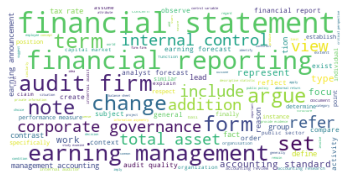

time: 280 ms


In [203]:
import matplotlib.pyplot as plt

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [204]:
NUM_OF_TOPICS = 70
NUM_OF_WORDS_IN_EACH_TOPIC = 20

time: 620 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [205]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

time: 633 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Unigrams

In [206]:
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=stop_list).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(dt3c['content_10'], NUM_OF_WORDS_IN_EACH_TOPIC)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top {} unigrams in the paper after removing stop words".format(NUM_OF_WORDS_IN_EACH_TOPIC)))
fig.show()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list_of_most_common_surnames', 'll', 'male', 'names', 'org', 'rep', 'shouldn', 've', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.



time: 52.6 s


## Bigrams

In [207]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=stop_list).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(dt3c['content_10'], NUM_OF_WORDS_IN_EACH_TOPIC)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top {} bigrams in the paper after removing stop words".format(NUM_OF_WORDS_IN_EACH_TOPIC)))
fig.show()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 2min 41s


In [208]:
"""
dt3c = pd.DataFrame(dt, columns=['file_path', 'Author', 'date', 'title'])
dt3c['content_3'] = dt['en_clean_content_3_stop_words_lemma']

dt3c.info()

unknown_lang_indexes = dt.index[dt['en_clean_content_3_lang'].str.match('UNKNOWN')]
dt3c = dt3c.drop(unknown_lang_indexes)

dt3c.info()
dt3c.reset_index(drop=True, inplace=True)
dt3c.info()
"""

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



"\ndt3c = pd.DataFrame(dt, columns=['file_path', 'Author', 'date', 'title'])\ndt3c['content_3'] = dt['en_clean_content_3_stop_words_lemma']\n\ndt3c.info()\n\nunknown_lang_indexes = dt.index[dt['en_clean_content_3_lang'].str.match('UNKNOWN')]\ndt3c = dt3c.drop(unknown_lang_indexes)\n\ndt3c.info()\ndt3c.reset_index(drop=True, inplace=True)\ndt3c.info()\n"

time: 3.89 ms


In [209]:
dt3c.info()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15189 entries, 0 to 15188
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15189 non-null  object
 1   Author           7794 non-null   object
 2   date             14976 non-null  object
 3   title            13543 non-null  object
 4   content_3        15189 non-null  object
 5   content_5        15189 non-null  object
 6   content_10       15189 non-null  object
 7   content_3_lang   15189 non-null  object
 8   content_5_lang   15189 non-null  object
 9   content_10_lang  15189 non-null  object
dtypes: object(10)
memory usage: 1.2+ MB
time: 3.7 s


# 4. LDA Topic Modeling

In [210]:
import pyLDAvis
import pyLDAvis.sklearn

count_vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words=stop_list,             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=5000,          
                            )

data_vectorized = count_vectorizer.fit_transform(dt3c['content_10'])

lda_model = LatentDirichletAllocation(n_components=NUM_OF_TOPICS, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.



time: 7min 18s


## 4.1. Visualize topics
By default the topics are projected to the 2D plane using PCoA on a distance matrix created using the <a href="https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence">Jensen-Shannon divergence</a> on the topic-term distributions. You can pass in a different multidimensional scaling function via the mds parameter. In addition to <b>pcoa</b>, other provided options are <b>tsne</b> and <b>mmds</b> which operate on the same JS-divergence distance matrix. Both tsne and mmds require that you have sklearn installed. 


Dimension reduction via Jensen-Shannon Divergence &
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html">TSNE - t-distributed Stochastic Neighbor Embedding</a>
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html#sklearn.manifold.MDS">MMDS - Metric Multidimensional Scaling</a> <a href="https://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html">Check Example</a>
- <a href="">PCOA - Principal Coordinate Analysis(aka Classical Multidimensional Scaling)</a>

Answer: https://stackoverflow.com/questions/50923430/what-does-the-parameter-mds-mean-in-the-pyldavis-sklearn-prepare-function

We used tsne below. Check for others: https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb
Also check to learn how LDAVis works: https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
And check the LDAVis from the original paper: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
Why LDAVis presentation: https://speakerdeck.com/bmabey/visualizing-topic-models

In [211]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, count_vectorizer, mds='tsne')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=               x          y  topics  cluster      Freq
topic                                                 
58     -5.136995  44.884823       1        1  5.577624
52     30.892590 -32.597176       2        1  4.924667
10    -17.787359  33.878349       3        1  4.021133
69      6.374316  43.789307       4        1  3.838142
64     -7.113618  58.080013       5        1  3.182539
60    -27.861227   8.089167       6        1  2.964313
55     38.926899 -44.429905       7        1  2.875597
50    -45.578514  39.805862       8        1  2.827505
59     -2.127658 -56.906422       9        1  2.506750
23    -42.679581 -23.338188      10        1  2.381585
68     13.161789  15.173490      11        1  2.269654
24    -14.706790  -5.034039      12        1  2.178342
32    -13.138696  15.521899      13        1  2.155884
9      30.053595 -53.851654      14        1  2.115566
8      16.442062 -57.014561      15        1  2.088156
19    -51.356892 -29.076273      16        1  1.933476
43     16.643429  31.074898      17        1  1.893145
27     16.404415  -2.632561      18        1  1.835364
18     -7.294629 -18.059263      19        1  1.792573
2      46.961552 -28.396786      20        1  1.732199
46      2.072933   5.983364      21        1  1.731741
30    -18.750036  70.284035      22        1  1.691912
34     24.053631 -67.970108      23        1  1.649488
39     36.515343 -15.668609      24        1  1.579539
57     15.479136 -42.212353      25        1  1.491536
25     63.224567 -84.722992      26        1  1.362513
4      51.583149  19.263340      27        1  1.320787
56    -36.219246  57.249573      28        1  1.314537
31    -57.454327  -0.420380      29        1  1.310872
21     74.486153  25.499775      30        1  1.274608
45     15.959477 -24.803299      31        1  1.274235
66    -31.549414  21.192329      32        1  1.265268
12      4.301099  66.898941      33        1  1.178121
67    -49.213673  61.133408      34        1  1.159656
48      6.673938 -33.912842      35        1  1.136110
1      55.413925 -45.170612      36        1  1.128309
44    -32.395794 -40.508675      37        1  1.099479
53     -1.727014  26.406393      38        1  1.092938
29    -26.117670  44.515236      39        1  1.089841
40      3.868659 -13.311059      40        1  1.075123
61    -21.581263 -23.850464      41        1  1.047227
51     18.790178  51.576210      42        1  1.026092
36    -71.755737  47.450993      43        1  1.016129
3      50.228043   8.924527      44        1  1.001462
33     33.759018  40.804867      45        1  0.984191
0     -34.743805  -2.239792      46        1  0.963290
54     33.741680  -0.007801      47        1  0.909761
22     46.093285 -63.004742      48        1  0.795119
49     -8.902919 -41.759132      49        1  0.793638
17    -47.985031  16.709244      50        1  0.771674
47    -30.233027  83.422523      51        1  0.652541
65     64.807213 -27.556635      52        1  0.629831
35    -74.834587 -11.879270      53        1  0.618425
6      72.701935 -79.898087      54        1  0.605136
62     26.432920  69.861862      55        1  0.602134
63     56.818962  -8.718982      56        1  0.597845
42     31.773098 -86.212105      57        1  0.567108
26     32.954391  19.674910      58        1  0.554965
13      6.419888 -80.763741      59        1  0.543127
20     55.327667  38.127663      60        1  0.508843
41     53.373344  62.792271      61        1  0.490902
37     83.719368  48.640491      62        1  0.489424
15     89.635109   4.946176      63        1  0.473456
38    -24.702051 -63.748108      64        1  0.442946
11      6.101858  96.087593      65        1  0.417485
7     -93.813599   8.651817      66        1  0.404112
5     -54.382748 -57.495781      67        1  0.267199
28    -65.083214  20.813763      68        1  0.243717
14     85.011459 -41.380745      69        1  0.159315
16    -35.320465 -92.517029      70        1  0.102076, topic_in

time: 29.8 s


In [212]:
print(count_vectorizer)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=5000, min_df=3,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=frozenset({'(former', '.002%.', '1990', '>', 'a',
                                      "a's", 'aaron', 'abbey', 'abbie',
                                      'abbott', 'abby', 'abdul', 'abdullah',
                                      'abe', 'abel', 'abell', 'abercrombie',
                                      'abernathy', 'abeyta', 'abigail', 'able',
                                      'ables', 'abner', 'abney', 'about',
                                      'above', 'abraham', 'abram', 'abrams',
                                      'abramson', ...}),
                strip_accents=None, token_pattern='[a-zA-Z0-9]{3,}',
                tokenizer=None, vocabulary=None)
time: 62.3 ms

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [213]:
print(data_vectorized.toarray())

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
time: 396 ms


In [214]:
topic_names = []
for i in range(NUM_OF_TOPICS):
  topic_names.append("Topic {}".format(i+1))

time: 568 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [215]:
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=count_vectorizer, lda_model=lda_model, n_words=NUM_OF_WORDS_IN_EACH_TOPIC)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords['topic_theme'] = topic_names
df_topic_keywords.set_index('topic_theme', inplace=True)
df_topic_keywords.T

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



topic_theme       Topic 1     Topic 2         Topic 3        Topic 4  \
Word 0        participant      market           datum           loss   
Word 1           judgment       share          number          asset   
Word 2          condition     company           table     intangible   
Word 3         assessment        cent           study           gain   
Word 4           investor  australian           index         income   
Word 5       manipulation     premium        analysis     impairment   
Word 6         experiment   insurance           score       goodwill   
Word 7             effect    exchange            base          write   
Word 8           perceive      period        category     accounting   
Word 9             result     finance         measure            sfa   
Word 10        management       trade           total    recognition   
Word 11          question        list            rank    measurement   
Word 12            assess       offer          period            net   
Word 13        perception    takeover          author         report   
Word 14      experimental         bid          result         future   
Word 15           provide      author            list         charge   
Word 16           suggest       study      publishing      recognize   
Word 17        manipulate        open  classification       estimate   
Word 18          response      result           paper      financial   
Word 19             panel     insurer            data  comprehensive   

topic_theme       Topic 5        Topic 6         Topic 7      Topic 8  \
Word 0              asset    shareholder             tax        fraud   
Word 1          liability           vote       avoidance   fraudulent   
Word 2            balance       election        taxpayer    detection   
Word 3          financial         voting        position       detect   
Word 4              sheet          share      aggressive      penalty   
Word 5                net            sme        planning  enforcement   
Word 6             income       proposal      compliance       action   
Word 7            expense       approval         evasion        crime   
Word 8          statement       investor       authority       commit   
Word 9            account          proxy  aggressiveness     criminal   
Word 10        accounting            pay          return      whistle   
Word 11             lease        advisor        strategy   brainstorm   
Word 12      depreciation      influence           taxis    violation   
Word 13            method           pill         shelter    financial   
Word 14           current          voter      difference  opportunity   
Word 15          property         poison         benefit     identify   
Word 16           operate     management        research     forensic   
Word 17             defer        company        activity     behavior   
Word 18         recognize       activist         expense       scheme   
Word 19           payment  institutional         measure  probability   

topic_theme        Topic 9        Topic 10        Topic 11        Topic 12  \
Word 0             earning         analyst      management    organisation   
Word 1             accrual        forecast         process  organisational   
Word 2          management         earning    organization       behaviour   
Word 3                firm     information     performance       recognise   
Word 4       discretionary  recommendation        strategy          labour   
Word 5             manager           issue        business       programme   
Word 6              report      management       strategic       emphasise   
Word 7              manage            firm         control        organise   
Word 8            abnormal        accuracy  organizational         analyse   
Word 9              income        investor     information    characterise   
Word 10           increase        revision          change          centre   
Word 11          

time: 205 ms


# 4.2. Extract Topics

In [216]:
# Create Document - Topic Matrix
lda_output2 = lda_model.transform(data_vectorized)

# column names
topicnames = df_topic_keywords.T.columns

# index names
docnames = ["Doc" + str(i) for i in range(len(dt3c))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output2, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.reset_index(inplace=True)
df_sent_topic= pd.merge(dt3c, df_document_topic, left_index=True, right_index=True)
df_sent_topic.drop('index', axis=1, inplace=True)

df_topic_theme = df_sent_topic[['file_path', 'dominant_topic']]

def label_theme(row):
    return "Topic " + str(row)
        
df_topic_theme['dominant_topic_theme'] = df_topic_theme['dominant_topic'].apply(label_theme)
df_topic_theme.head(15)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-216-9689e41583c7>:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



file_path  \
0   /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf   
1   /Users/farukcankaya/Google Drive/AllPapers/8_AH/140_AH.pdf   
2   /Users/farukcankaya/Google Drive/AllPapers/8_AH/611_AH.pdf   
3   /Users/farukcankaya/Google Drive/AllPapers/8_AH/294_AH.pdf   
4   /Users/farukcankaya/Google Drive/AllPapers/8_AH/123_AH.pdf   
5   /Users/farukcankaya/Google Drive/AllPapers/8_AH/672_AH.pdf   
6   /Users/farukcankaya/Google Drive/AllPapers/8_AH/394_AH.pdf   
7   /Users/farukcankaya/Google Drive/AllPapers/8_AH/398_AH.pdf   
8   /Users/farukcankaya/Google Drive/AllPapers/8_AH/298_AH.pdf   
9   /Users/farukcankaya/Google Drive/AllPapers/8_AH/603_AH.pdf   
10  /Users/farukcankaya/Google Drive/AllPapers/8_AH/152_AH.pdf   
11  /Users/farukcankaya/Google Drive/AllPapers/8_AH/703_AH.pdf   
12  /Users/farukcankaya/Google Drive/AllPapers/8_AH/386_AH.pdf   
13  /Users/farukcankaya/Google Drive/AllPapers/8_AH/660_AH.pdf   
14  /Users/farukcankaya/Google Drive/AllPapers/8_AH/131_AH.pdf   

    dominant_topic dominant_topic_theme  
0               10             Topic 10  
1               69             Topic 69  
2               13             Topic 13  
3               43             Topic 43  
4               18             Topic 18  
5                9              Topic 9  
6               23             Topic 23  
7               22             Topic 22  
8               19             Topic 19  
9               45             Topic 45  
10              27             Topic 27  
11              56             Topic 56  
12              49             Topic 49  
13              15             Topic 15  
14              44             Topic 44

time: 23 s


## 4.3. Make Prediction

In [217]:
print(lda_output.shape)
topic_sum = pd.DataFrame(np.sum(lda_output, axis = 1))
print(topic_sum.shape)

(15189, 70)
(15189, 1)
time: 3.67 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [218]:
column_names = ['file_path', 'content_10'] + topic_names + ['sum']

# Turn our docs_nmf array into a data frame
doc_topic_df = pd.DataFrame(data = lda_output)

# Merge all of our article metadata and name columns
doc_topic_df = pd.concat([dt3c[['file_path', 'content_10']], 
                          doc_topic_df, topic_sum], axis = 1)


time: 66.3 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [219]:
doc_topic_df.columns = column_names

time: 695 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [220]:
doc_topic_df.head(1)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



file_path  \
0  /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

time: 57.4 ms


In [221]:
doc_topic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15189 entries, 0 to 15188
Data columns (total 73 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file_path   15189 non-null  object 
 1   content_10  15189 non-null  object 
 2   Topic 1     15189 non-null  float64
 3   Topic 2     15189 non-null  float64
 4   Topic 3     15189 non-null  float64
 5   Topic 4     15189 non-null  float64
 6   Topic 5     15189 non-null  float64
 7   Topic 6     15189 non-null  float64
 8   Topic 7     15189 non-null  float64
 9   Topic 8     15189 non-null  float64
 10  Topic 9     15189 non-null  float64
 11  Topic 10    15189 non-null  float64
 12  Topic 11    15189 non-null  float64
 13  Topic 12    15189 non-null  float64
 14  Topic 13    15189 non-null  float64
 15  Topic 14    15189 non-null  float64
 16  Topic 15    15189 non-null  float64
 17  Topic 16    15189 non-null  float64
 18  Topic 17    15189 non-null  float64
 19  Topic 18    15189 non-nul

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [222]:
# Remove articles with topic sum = 0, then drop sum column
doc_topic_df = doc_topic_df[doc_topic_df['sum'] != 0]
doc_topic_df.drop(columns = 'sum', inplace = True)

# Reset index then save
doc_topic_df.reset_index(drop = True, inplace = True)
#doc_topic_df.to_pickle('counter_vectorizer_LDA_8topics_stemmed.pkl')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 11.1 ms


In [223]:
doc_topic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15189 entries, 0 to 15188
Data columns (total 72 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file_path   15189 non-null  object 
 1   content_10  15189 non-null  object 
 2   Topic 1     15189 non-null  float64
 3   Topic 2     15189 non-null  float64
 4   Topic 3     15189 non-null  float64
 5   Topic 4     15189 non-null  float64
 6   Topic 5     15189 non-null  float64
 7   Topic 6     15189 non-null  float64
 8   Topic 7     15189 non-null  float64
 9   Topic 8     15189 non-null  float64
 10  Topic 9     15189 non-null  float64
 11  Topic 10    15189 non-null  float64
 12  Topic 11    15189 non-null  float64
 13  Topic 12    15189 non-null  float64
 14  Topic 13    15189 non-null  float64
 15  Topic 14    15189 non-null  float64
 16  Topic 15    15189 non-null  float64
 17  Topic 16    15189 non-null  float64
 18  Topic 17    15189 non-null  float64
 19  Topic 18    15189 non-nul

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [224]:
doc_topic_df[['file_path']+topic_names].head(3).T

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0  \
file_path  /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf   
Topic 1                                                   7.31475e-06   
Topic 2                                                   7.31475e-06   
Topic 3                                                   7.31475e-06   
Topic 4                                                   7.31475e-06   
Topic 5                                                   7.31475e-06   
Topic 6                                                   7.31475e-06   
Topic 7                                                   0.000801635   
Topic 8                                                   7.31475e-06   
Topic 9                                                   7.31475e-06   
Topic 10                                                  7.31475e-06   
Topic 11                                                     0.261818   
Topic 12                                                  7.31475e-06   
Topic 13                                                  7.31475e-06   
Topic 14                                                  7.31475e-06   
Topic 15                                                  7.31475e-06   
Topic 16                                                    0.0192336   
Topic 17                                                  7.31475e-06   
Topic 18                                                  7.31475e-06   
Topic 19                                                  7.31475e-06   
Topic 20                                                  7.31475e-06   
Topic 21                                                  7.31475e-06   
Topic 22                                                  7.31475e-06   
Topic 23                                                  7.31475e-06   
Topic 24                                                  7.31475e-06   
Topic 25                                                  7.31475e-06   
Topic 26                                                  7.31475e-06   
Topic 27                                                  7.31475e-06   
Topic 28                                                     0.180589   
Topic 29                                                  7.31475e-06   
Topic 30                                                    0.0300377   
Topic 31                                                  7.31475e-06   
Topic 32                                                   0.00347533   
Topic 33                                                     0.131779   
Topic 34                                                  7.31475e-06   
Topic 35                                                  7.31475e-06   
Topic 36                                                  7.31475e-06   
Topic 37                                                  7.31475e-06   
Topic 38                                                  7.31475e-06   
Topic 39                                                  7.31475e-06   
Topic 40                                                  7.31475e-06   
Topic 41                                                  7.31475e-06   
Topic 42                                                  7.31475e-06   
Topic 43                                                  7.31475e-06   
Topic 44                                                  7.31475e-06   
Topic 45                                                  7.31475e-06   
Topic 46                                                  7.31475e-06   
Topic 47                                                  7.31475e-06   
Topic 48                                                  7.31475e-06   
Topic 49                                                  7.31475e-06   
Topic 50                                                    0.0155451   
Topic 51                                                  7.31475e-06   
Topic 52                                                  7.31475e-06   
Topic 53                                                   0.00993704   
Topic 54                                             

time: 25.1 ms


In [225]:
topic_array = np.array(doc_topic_df[topic_names])

print(topic_array.shape)

print(topic_array[0])

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(15189, 70)
[7.31475386e-06 7.31475386e-06 7.31475386e-06 7.31475386e-06
 7.31475386e-06 7.31475386e-06 8.01634863e-04 7.31475386e-06
 7.31475386e-06 7.31475386e-06 2.61818052e-01 7.31475386e-06
 7.31475386e-06 7.31475386e-06 7.31475386e-06 1.92335509e-02
 7.31475386e-06 7.31475386e-06 7.31475386e-06 7.31475386e-06
 7.31475386e-06 7.31475386e-06 7.31475386e-06 7.31475386e-06
 7.31475386e-06 7.31475386e-06 7.31475386e-06 1.80589093e-01
 7.31475386e-06 3.00377489e-02 7.31475386e-06 3.47533119e-03
 1.31779386e-01 7.31475386e-06 7.31475386e-06 7.31475386e-06
 7.31475386e-06 7.31475386e-06 7.31475386e-06 7.31475386e-06
 7.31475386e-06 7.31475386e-06 7.31475386e-06 7.31475386e-06
 7.31475386e-06 7.31475386e-06 7.31475386e-06 7.31475386e-06
 7.31475386e-06 1.55450787e-02 7.31475386e-06 7.31475386e-06
 9.93703927e-03 7.31475386e-06 7.31475386e-06 7.31475386e-06
 2.33140919e-02 7.31475386e-06 1.17520011e-01 3.98270942e-02
 1.55652729e-01 7.31475386e-06 7.31475386e-06 7.31475386e-06
 7.31475386e

## 4.4. Prepare pre-trained model
### 4.4.1. Save the model
Save the model to use as pre-trained model on the https://simple-recommender.herokuapp.com/ website.

In [226]:
import pickle

topic_names = []
for i in range(NUM_OF_TOPICS):
  topic_names.append("Topic {}".format(i+1))

topic_array = np.array(doc_topic_df[topic_names])
norms = np.linalg.norm(topic_array, axis = 1)

pickle.dump( norms, open( "model__norms.pkl", "wb" ) )
pickle.dump( topic_array, open( "model__topic_array.pkl", "wb" ) )
df_topic_keywords.to_pickle('model__df_topic_keywords.pkl')
pickle.dump( doc_topic_df, open( "model__doc_topic_df.pkl", "wb" ) )
pickle.dump( lda_model, open( "model__lda_model.pkl", "wb" ) )
pickle.dump( count_vectorizer, open( "model__count_vectorizer.pkl", "wb" ) )
pickle.dump( stop_list, open( "model__stop_list.pkl", "wb" ) )



/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 926 ms


### 4.4.2. Add Title, Author, metadata to core model
Use useful data from RELAVENT_DATA.xlsx

In [227]:
x = dt3c.copy()
# Paper Name, Author Name(s), Year and Journal
print(x['date'].isna().sum())
x['date'] = x['date'].fillna(0)
print(x['date'].isna().sum())

doc_topic_df['year'] = x['date']

213
0
time: 19.6 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [228]:
def combine_authors(author_list):
  if isinstance(author_list, list):
    return ', '.join(author_list)

  return author_list

x['Author'] = x['Author'].fillna('-')
x['authors'] = x['Author'].apply(combine_authors)

doc_topic_df['authors'] = x['authors']

time: 13.7 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [229]:
print(x['title'].isna().sum())
x['title'] = x['title'].fillna('-')
print(x['title'].isna().sum())

doc_topic_df['title'] = x['title']

1646
0
time: 6.23 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [230]:
def journal_name(text):
  text = get_file_name(text)
  t = re.findall('([0-9]+)_([a-zA-Z]+)', text, re.IGNORECASE)
  return [i[1] for i in t][0]

doc_topic_df['journal'] = x['file_path'].apply(journal_name)
doc_topic_df['journal'].head(5)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0    AH
1    AH
2    AH
3    AH
4    AH
Name: journal, dtype: object

time: 66 ms


In [189]:
rt = pd.read_excel('/Users/farukcankaya/FC/GoogleDrive/DATA_RELEVANT.xlsx')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning:

This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning:

This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning:

This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.it

time: 19.5 s


In [231]:
rt.iloc[rt.index[rt['Filename'].str.match(get_file_name(dt['file_path'][0]))][0]]['Title']

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



'The effect of system characteristics, stage of adoption, and experience on institutional explanations for ERP systems choice'

time: 53.2 ms


In [232]:
titles = []
for i in range(0, len(dt3c['file_path'])):
  if rt['Filename'].str.match(get_file_name(dt3c['file_path'][i])).any():
    titles.append(rt.iloc[rt.index[rt['Filename'].str.match(get_file_name(dt3c['file_path'][i]))][0]]['Title'])
  else:
    titles.append(dt3c['title'][i])
      

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 3min 23s


In [233]:
pickle.dump( doc_topic_df, open( "model__doc_topic_df.pkl", "wb" ) )

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 1.09 s


In [234]:
# LOAD pre-trained model if you just want to make prediction here.
"""
norms     = pickle.load( open( "model__norms.pkl", "rb" ) )
topic_array     = pickle.load( open( "model__topic_array.pkl", "rb" ) )
df_topic_keywords = pickle.load( open( "model__df_topic_keywords.pkl", "rb" ) )
doc_topic_df = pickle.load( open( "model__doc_topic_df.pkl", "rb" ) )
lda_model = pickle.load( open( "model__lda_model.pkl", "rb" ) )
count_vectorizer   = pickle.load( open( "model__count_vectorizer.pkl", "rb" ) )
stop_list     = pickle.load( open( "model__stop_list.pkl", "rb" ) )
"""

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



'\nnorms     = pickle.load( open( "model__norms.pkl", "rb" ) )\ntopic_array     = pickle.load( open( "model__topic_array.pkl", "rb" ) )\ndf_topic_keywords = pickle.load( open( "model__df_topic_keywords.pkl", "rb" ) )\ndoc_topic_df = pickle.load( open( "model__doc_topic_df.pkl", "rb" ) )\nlda_model = pickle.load( open( "model__lda_model.pkl", "rb" ) )\ncount_vectorizer   = pickle.load( open( "model__count_vectorizer.pkl", "rb" ) )\nstop_list     = pickle.load( open( "model__stop_list.pkl", "rb" ) )\n'

time: 2.03 ms


## 4.5. Measure similarity

In [235]:
def compute_dists(top_vec, topic_array):
    '''
    Returns cosine distances for top_vec compared to every article
    '''
    dots = np.matmul(topic_array, top_vec)
    input_norm = np.linalg.norm(top_vec)
    co_dists = dots / (input_norm * norms)
    return co_dists
  
def produce_rec(top_vec, topic_array, doc_topic_df, rand = 15):
    '''
    Produces a recommendation based on cosine distance.
    rand controls magnitude of randomness.
    '''
#    top_vec = top_vec + np.random.rand(30,)/(np.linalg.norm(top_vec)) * rand
    co_dists = compute_dists(top_vec, topic_array)
    return doc_topic_df.loc[np.argmax(co_dists)]

time: 693 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [236]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Define function to predict topic for a given new question.
def predict_topic(text, nlp=nlp):
    global sent_to_words

    # Clean
    for i in range(len(text)):
      text[i] = clean_text(text[i])
      
    # Remove stopwords
    for i in range(len(text)):
      text[i] = remove_stopwords(text[i])
    
    # Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Lemmatize is skipped !!!
    # mytext_3_1 = []
    # for sent in mytext_2:
    #   mytext_3_1.append(" ".join(sent))
    # Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    #print('Text after lemmatization ({} characters):'.format(len(mytext_3[0])))
    #print(mytext_3[0][0:100]+" ...")
    
    # stemming is skipped !!!
    #mytext_3_1 = []
    #for t in mytext_3:
    #  mytext_3_1.append(stem_text(t))
    
    # Vectorize transform
    mytext_4 = count_vectorizer.transform(mytext_3)
    
    #print('Count vectorizer of transformed text: {}'.format(mytext_4.shape))
    #print('Vectorized data {}'.format(data_vectorized.shape))
    #print('First 100 Feature names:')
    #print(count_vectorizer.get_feature_names()[:100])
    #print('')
    

    # LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

time: 2.52 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## 4.6 Make single prediction

In [237]:
# Predict the topic
TAR_6 = ["We examine how subjective performance evaluations are influenced by the level and controllability of an accompanying measure of a separate performance dimension. In our experiment, supervisors evaluate the office administration perfor- mance of a hypothetical subordinate. We find that supervisors’ subjective evaluations are directionally influenced by an accompanying objective measure of sales perfor- mance, even after excluding participants who perceive informativeness across measures. Consistent with concerns for fairness and motivation, we also find an asymmetric uncontrollability effect—supervisors’ evaluations are higher when an uncontrollable factor decreases the subordinate’s sales (i.e., they compensate for bad luck), but are not lower when the uncontrollable factor increases the subordinate’s sales (i.e., they do not punish for good luck). This evidence suggests that supervisors use discretion provided to evaluate performance on one task to adjust for perceived deficiencies in the evaluation of performance on other tasks. Our study integrates theories of cognitive bias and motivation, highlighting the need to consider the potentially interactive effects of different performance measures in multi-task settings I. INTRODUCTION Organizational incentive systems often allow managerial discretion in the evaluation of employee performance (Murphy and Oyer 2003). Subjective performance evaluation allows managers to use noncontractible information to assess actions and efforts that objective measures (such as those produced by the accounting system) are not able to capture, creating a more complete depiction of employee performance (Bol 2008).1 Subjectivity can therefore be useful in reducing risk to employees and improving the incentive alignment of the firm’s performance measurement system (Baker et al. 1994; Bushman et al. 1996; Hayes and Schaefer 2000).2 Many performance measurement systems include both objective measures and subjective evaluations (Prendergast 1999; Gibbs et al. 2004). While designed to capture separate dimensions of employee performance, these different measurement types can influence each other. For example, theories from psychology and organizational behavior suggest that subjective judgments can be unduly influenced by an individual’s knowledge of other, unrelated information (Nisbett et al. 1981; Bond et al. 2007). Such an influence could limit the complementary role of subjective evaluation in improving the overall informativeness of the measures used to evaluate performance. We examine how supervisors’ subjective performance evaluations are affected by the level and controllability of an objective measure of a separate aspect of performance. We analyze a two-dimensional employment setting in which an employee’s performance on one dimension (i.e., task) is measured objectively, while performance on the other dimension is evaluated subjectively by the supervisor. In many such settings, the objective performance measure is known by the supervisor before s/he subjectively evaluates the employee’s performance on the other dimension (Huber et al. 1987; Bommer et al. 1995). Our first research question examines whether the level of the objective measure has a directional impact on the supervisor’s subjective evaluation. Specifically, we examine whether, consistent with cognitive distortion, supervisors bias their subjective evaluations of performance on one dimension to be consistent with an objective measure of performance on a separate and unrelated dimension.3 Our second research question considers how such a spillover effect differs when the controllability of the objective performance measure is relatively low. Uncontrollability introduces noise and error into the performance measurement system (Feltham and Xie 1994), and has been shown to affect attribution judgments (Tan and Lipe 1997). Employees are likely to perceive uncontrollable performance measures to be unfair when the uncontrollability reduces measured performance. Perceptions of unfairness in compensation lead to reduced job satisfaction and motivation (Cohen-Charash and Spector 2001; Colquitt et al. 2001). We examine whether this expectation is reflected in supervisors’ use of their discretion, even when that discretion is provided for the evaluation of a separate task. Specifically, we examine whether supervisors use the discretion in their subjective evaluations to adjust for (or offset) the effects of an uncontrollable objective measure. Consistent with concerns for fairness and employee motivation, we predict that supervisors will make such an adjustment when the uncontrollable factor reduces measured performance (i.e., the employee suffers from bad luck) but not when it increases measured performance (i.e., the employee benefits from good luck). In our experiment, experienced supervisors employed by a large state university participate as evaluators in a hypothetical case setting. Participants assume the role of a regional director with supervisory authority over district managers who have both sales- and office administration-related duties. Objective individual sales information is given, after which participants are charged with subjectively evaluating the office administration performance of one district manager based on personal notes and staff interview responses, which are held constant in all conditions. The experiment employs a 2 3 2 þ 1 between-subjects design. In four treatment conditions, we manipulate the level of the manager’s individual sales at two levels by varying the objective sales score (high and low), and we manipulate the controllability of the individual sales measure at two levels by varying whether significant but uncontrollable events impacted the manager’s sales during the period. A fifth (control) condition includes only the information about the manager’s office administration performance. We find that supervisors’ subjective evaluations of the manager’s office administration performance are significantly higher (lower) when the objective level of the manager’s individual sales measure is relatively high (low). By excluding those participants who perceived the individual sales measure to be informative about the manager’s office administration performance in our primary analysis, we provide evidence of cognitive distortion of performance information as a result of exposure to the objective measure. We also find that the effect of the objective measure depends on its controllability. Specifically, participants use their subjective evaluations to adjust for the impact of uncontrollable events on the sales measure. Consistent with theory, this effect is asymmetric—participants’ evaluations are higher (relative to the high controllability condition) when the uncontrollable factor leads to an unfavorable outcome, but are no lower when the uncontrollable factor leads to a favorable outcome. Thus, we find that participants use their discretion to compensate for bad luck, but not to punish for good luck. This study contributes to the accounting and management literatures on performance evaluation. Prior research on bias in performance evaluation has found that supervisors’ subjective evaluations of current performance may be directionally influenced by prior performance information (Murphy et al. 1985; Huber et al. 1987; Kravitz and Balzer 1992) or information from different sources (Blakely 1993; Murphy and Cleveland 1995; Bono and Colbert 2005). Our study contributes to this line of research by showing that cognitive distortion can cause spillover from the objective evaluation of one dimension of performance to the subjective evaluation of performance on a separate and unrelated dimension. Prior research has also found evidence that controllability concerns can affect evaluators’ judgments in single-dimension performance-evaluation settings. For example, Tan and Lipe (1997) find that controllability moderates outcome effects in evaluators’ judgments (also see Brown and Solomon 1987). Our study reveals a very different controllability effect. Specifically, our results suggest that supervisors can use discretion that is provided for the evaluation of performance on a particular dimension to ‘‘correct’’ perceived deficiencies in other areas of the evaluation system. While the use of ‘‘borrowed’’ discretion can yield motivational benefits for employees, the intended benefits of that discretion (i.e., accurate reflection of performance on a specific dimension) can be reduced. Overall, our evidence indicates that the known level of an objective performance measure compromises the effectiveness of subjective performance evaluation for completing the picture of employee performance. Thus, our results have implications for the weight, timing, and nature of subjectivity in compensation contracting, suggesting that consideration of different measurement types in isolation can lead to incomplete conclusions about the optimal design of performance measurement systems. An asymmetric pattern of compensation payouts, in which managers are sheltered from downside risk but are allowed the advantages of upside risk, has been demonstrated in accounting"]
AOS_3 = ["This paper is focused on the way in which inter®rm relations can be drawn up and controlled. Drawing on con- tracting theories a model is built of the management control structure of inter®rm relationships. The model consists of three control patterns and of contingency factors that in ̄uence the choices between the patterns. Particular attention is paid to the role of trust. In building our model we take the perspective of the outsourcer. We try to re®ne our model by conducting case research in the ®eld of industrial renovation and industrial maintenance. In this ®eld we observed changes in the way outsourcing relationships are controlled. Case research can be very helpful for gaining insights into factors that in ̄uence the establishment of control structures of inter®rm relationships. By comparing the results of our case research we found institutional, strategic, cultural and historical factors to be of great importance for these control structures. 5 1999 Elsevier Science Ltd. All rights reserved. The boundaries of ®rms are continuously sub- ject to changes. Firms add new activities, hive o􏰁 existing activities and set up new forms of coop- eration with other ®rms. The concentration on core activities is a tendency that already started several years ago. Non-core activities are hived o􏰁, so that the ®rm can concentrate on the activ- ities which it can perform well and which can thus produce the highest added value. Insight into which activities belong to the non-core activities is subject to changes too. We observe that conglom- erates with a great variety of products hive o complete product lines, but we also ®nd that ®rms, although they do not change their product mix, leave the production of components to other ®rms. We can also observe that ®rms outsource the provision of supporting services even more. Even services which are essential for the continuity of the ®rm, such as administration, information technology and maintenance. When the out- sourcing concerns essential components and ser- vices we observe the setting up of close forms of cooperation between ®rms. Hiving o􏰁 essential components and services requires a speci®c embeddedness of the outsourcing relation in order to guarantee its continuity and to retain the eco- nomic advantages of outsourcing in the long run. This makes demands on the macro as well as micro level. On the macro level these develop- ments must be supported by legal and institutional frameworks (such as contract law and the attitude of branch organisations and the trade unions). On the micro level they make demands on the orga- nisation of the ®rm's own activities, the coordina- tion with the suppliers and the employees' willingness to work closely together with people from outside their own ®rm. The structuring and control of inter®rm relations require the establish- ment of suitable management control systems and processes. This study is in particular aimed at the demands outsourcing relations make on the micro level. The question is: how can ®rms which enter into strategic alliances with other ®rms structure the management control of such inter®rm relationships? Management control and management accounting research usually concentrates on rela- tions within organisations with varying degrees of decentralisation of decision making. Robert Anthony's (1965, 1988) well-known framework in which the decomposition of the organisation into responsibility centers is paramount, is the implicit or explicit point of departure for a lot of formal behavioural and contingency research in manage- ment control. In numerous organisations a hor- izontalisation of management control relations can be observed. These control relations are not hierarchically based but are relations between equal internal parties. Customer-supplier relation systems are being set up with forms of internal contracting (service level agreements), e.g. with respect to facility services (Van der Meer-Kooistra, 1994; Vosselman, 1996). There used to be captive buyers and sellers, but now it is no longer excep- tional for departments to be allowed to deliver or to buy on external markets within rather  ̄exible limits. Otley (1994) too observes such a horizontalisation and proposes a broader management control fra- mework. Research into horizontal management control relations should not remain restricted to intra®rm relations, but be extended to inter®rm relations. Recently Hopwood urged ``(the) exam- ination of some of the accounting and informational consequences of more explicit concerns with the management of the supply chain and a more con- scious questioning of what activities reside within and without the enterprise'' (Hopwood, 1996, p. 590). In the relevant literature little attention is given to management control issues with regard to forms of cooperation between independent com- panies (inter®rm relations). It is in particular the strategic cost management literature (Cooper, 1995; Shank & Govindarajan, 1993) which draws attention to the importance of looking beyond the boundaries of the ®rm. These publications emphasise the value chain approach, which not only focuses on the relations between the various subsequent activities within the ®rm but also on the ®rm's relations with the suppliers of raw materials, components etc. and the buyers. Berry (1995) also focuses on extra-organisational control problems, in particular control in network orga- nisations. According to Gietzmann (1996) the role of the management accountant is changing due to control beyond the boundaries of the concern. When deciding on what should or should not be contracted out this role is much more complex than just calculating the production costs and comparing them with the market price. Make or buy decisions are becoming more and more of a strategic nature (see e.g. Tayles & Drury, 1997). ``The management accountant should play a cri- tical support role in the strategy debate concerning which elements (subcomponents) of product development can be outsourced, which should be developed in house and which do not warrant development since o􏰁 the shelf subcomponents su􏰂ce'' (Gietzmann, p. 624). Therefore the man- agement accountant needs not only information about the production costs and market prices but he also needs information about the costs and bene®ts of the speci®c forms of governance connected with these choices. Nowadays many make or buy decisions have evolved into what could be called `extended make or buy' decisions. An extended make or buy deci- sion can be divided into three separate, but inter- related elements. Firstly, the decision to purchase goods or services on a structural basis from third parties or to produce the goods or services in- house. Secondly, in the case of purchasing from third parties, the decision regarding the party or parties contracted. The nature of the party or parties in ̄uences the chance, and extent, of relational risks. Thirdly, decisions regarding the design of the internal management control system or the design of the outsourcing relationship."]
topic, prob_scores = predict_topic(text = TAR_6)
print('topic')
print(topic)
print('')
print('prob_scores')
print(prob_scores[0])
print("shape of prob_scores: {}".format(prob_scores[0].shape))
print('')


print("Try to make recommendation. Inputs:")
print("- prob_scores")
print("- topic_array: {} prob. distribution of topics for each document that is calculated by LDA".format(topic_array.shape))
print("- doc_topic_df: {} that is actually output of the LDA but combined with file_path, etc.".format(doc_topic_df.shape))
print('')

produce_rec(prob_scores.flatten(), topic_array, doc_topic_df)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



topic
['performance', 'manager', 'incentive', 'compensation', 'measure', 'contract', 'pay', 'effort', 'base', 'bonus', 'executive', 'increase', 'ceo', 'managerial', 'agent', 'principal', 'period', 'effect', 'ceos', 'level']

prob_scores
[6.43358305e-02 2.68024658e-05 2.68024658e-05 2.68024658e-05
 2.68024658e-05 2.68024658e-05 2.52475979e-03 2.68024658e-05
 2.68024658e-05 2.68024658e-05 2.68024658e-05 2.68024658e-05
 2.68024658e-05 2.68024658e-05 2.68024658e-05 2.68024658e-05
 2.68024658e-05 2.68024658e-05 2.68024658e-05 2.68024658e-05
 2.68024658e-05 2.68024658e-05 4.54861103e-03 2.68024658e-05
 3.32710392e-01 2.68024658e-05 2.68024658e-05 2.68024658e-05
 2.68024658e-05 2.68024658e-05 2.68024658e-05 2.68024658e-05
 2.68024658e-05 1.58546336e-02 2.68024658e-05 2.68024658e-05
 2.72726737e-03 2.68024658e-05 2.68024658e-05 2.68024658e-05
 3.08147624e-03 2.68024658e-05 2.68024658e-05 2.68024658e-05
 6.31989332e-03 2.68024658e-05 2.68024658e-05 2.68024658e-05
 2.68024658e-05 2.68024658e-05 

file_path                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

time: 455 ms


# 5. Calculate Accuracy
## 5.1. Calculate Top-5 Accuracy

In [238]:
from sklearn.metrics.pairwise import cosine_similarity

def produce_rec_top_n(top_vec, topic_array, doc_topic_df, n=5):
    co_dists = compute_dists(top_vec, topic_array)
    index_top_n = np.argpartition(co_dists, -n)[-n:]
    index_top_n = index_top_n[np.argsort(-co_dists[index_top_n])]
    return doc_topic_df.loc[index_top_n]
  
topic, prob_scores = predict_topic(text = TAR_6)

topic_columns = ['Topic '+str(i) for i in range(1,df_topic_keywords.shape[0]+1)]
recs = produce_rec_top_n(prob_scores.flatten(), topic_array, doc_topic_df)

rec_top_1 = recs[topic_columns].head(1).values

print('rec_top_1:')
print(rec_top_1)
print('prob_scores:')
print(prob_scores.flatten())
print('cosine_similarity:')
print(cosine_similarity(rec_top_1,prob_scores))

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



rec_top_1:
[[9.77720683e-02 6.74172453e-06 2.36816121e-02 6.74172453e-06
  6.74172453e-06 6.74172453e-06 6.93412210e-04 6.74172453e-06
  6.74172453e-06 6.74172453e-06 6.74172453e-06 6.74172453e-06
  6.74172453e-06 6.74172453e-06 6.74172453e-06 6.74172453e-06
  6.74172453e-06 6.74172453e-06 6.74172453e-06 6.74172453e-06
  6.74172453e-06 2.35869064e-03 7.28934337e-03 6.74172453e-06
  2.69144331e-01 6.74172453e-06 1.51218947e-02 6.74172453e-06
  6.74172453e-06 6.74172453e-06 1.74398172e-02 6.74172453e-06
  6.74172453e-06 4.74799975e-03 6.74172453e-06 6.74172453e-06
  8.88905297e-03 6.74172453e-06 1.57904554e-03 6.74172453e-06
  1.79846268e-03 6.74172453e-06 6.74172453e-06 6.74172453e-06
  6.74172453e-06 2.06574704e-03 6.74172453e-06 6.74172453e-06
  6.74172453e-06 1.26454285e-02 6.74172453e-06 6.74172453e-06
  6.74172453e-06 6.74172453e-06 6.74172453e-06 6.74172453e-06
  6.74172453e-06 6.74172453e-06 6.74172453e-06 6.74172453e-06
  2.63986647e-01 6.71104307e-03 6.74172453e-06 6.74172453e-

In [239]:
recs['file_path']

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



7631        /Users/farukcankaya/Google Drive/AllPapers/1_TAR/6_TAR.pdf
11184     /Users/farukcankaya/Google Drive/AllPapers/4_AOS/898_AOS.pdf
850      /Users/farukcankaya/Google Drive/AllPapers/11_BAR/433_BAR.pdf
7247      /Users/farukcankaya/Google Drive/AllPapers/1_TAR/158_TAR.pdf
2494      /Users/farukcankaya/Google Drive/AllPapers/3_JAR/215_JAR.pdf
Name: file_path, dtype: object

time: 4.53 ms


## 5.2. Calculate Top 1,5,20,100 Accuracy

In [240]:
def accuracy_n(file_path, data, top_n=[1]):
  topic, prob_scores = predict_topic([data])

  topic_columns = ['Topic '+str(i) for i in range(1,df_topic_keywords.shape[0]+1)]
  recs = produce_rec_top_n(prob_scores.flatten(), topic_array, doc_topic_df, max(top_n))

  existence = []
  
  for n in top_n:    
    if recs['file_path'].head(n).str.contains(get_file_name(file_path)).any():
      existence.append(1)
    else:
      existence.append(0)

  return pd.Series(existence)

time: 802 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [241]:
## PARALLEL TEST
xx = dt.copy().drop(unknown_lang_indexes_content_3)
xx = xx.drop(unknown_lang_indexes_content_10)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], top_n), axis=1)
xx.info()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:390: UserWarning:

Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:390: UserWarning:

Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:390: UserWarning:

Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1

/

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15750 entries, 0 to 15750
Columns: 2445 entries, file_path to acc_top_100
dtypes: float64(330), int64(337), object(1778)
memory usage: 293.9+ MB
time: 9min 20s


In [242]:
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

Top-1 Score:0.3417142857142857
Top-5 Score:0.5310476190476191
Top-10 Score:0.6081269841269842
Top-20 Score:0.6821587301587302
Top-50 Score:0.7671111111111111
Top-100 Score:0.8276190476190476
time: 14.2 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

